In [2]:
import pandas as pd
%pylab inline

assert (pd.__version__ == '0.16.0'), "Version de Pandas distinta a la usada originalmente!"

Populating the interactive namespace from numpy and matplotlib


# Time Series Analysis

A time series is a sequence of data points, typically consisting of successive measurements made over a time interval. Examples of time series are ocean tides, counts of sunspots, and the daily closing value of the Dow Jones Industrial Average. Time series are very frequently plotted via line charts. Time series are used in statistics, signal processing, pattern recognition, econometrics, mathematical finance, weather forecasting, intelligent transport and trajectory forecasting,[1] earthquake prediction, electroencephalography, control engineering, astronomy, communications engineering, and largely in any domain of applied science and engineering which involves temporal measurements.

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. **Time series forecasting is the use of a model to predict future values based on previously observed values.** While regression analysis is often employed in such a way as to test theories that the current values of one or more independent time series affect the current value of another time series, this type of analysis of time series is not called "time series analysis", which focuses on comparing values of a single time series or multiple dependent time series at different points in time.[2]

https://en.wikipedia.org/wiki/Time_series

## Load Data

In [98]:
df = pd.read_csv('./data/data.csv')
df.head()

,month,day,hora,estacion,cantidadpasos
0,1,1,0,ALB,106
1,1,1,0,AVE,984
2,1,1,0,DEL,671
3,1,1,0,ILL,88
4,1,1,1,ALB,407


In [151]:
ts = pd.pivot_table(df, values='cantidadpasos',columns=['estacion'], index= ['month', 'day','hora'])
ts.reset_index(inplace=True)
ts.drop(['RET','SAR'], axis=1, inplace=True)

ts['fecha'] = pd.to_datetime(2014*10000+ts.month*100+ts.day,format='%Y%m%d')
ts['is_weekend'] = ts.fecha.dt.weekday.isin([0,6])
ts['is_peak_hour'] = ts.hora.isin([12,13,17,18])
ts['is_going_to_work'] = ts.hora.isin([6,7,8,9,10])
ts['is_going_to_home'] = ts.hora.isin([16,17,18,19,20])

ts_test = ts[ts.month == 8]
ts = ts[ts.month.isin([1,2,3,4,5,6,7])]
ts.head()

estacion,month,day,hora,ALB,AVE,DEL,ILL,fecha,is_weekend,is_peak_hour,is_going_to_work,is_going_to_home
0,1,1,0,106,984,671,88,2014-01-01,False,False,False,False
1,1,1,1,407,4519,2502,361,2014-01-01,False,False,False,False
2,1,1,2,641,6198,3192,500,2014-01-01,False,False,False,False
3,1,1,3,428,4386,2241,456,2014-01-01,False,False,False,False
4,1,1,4,213,2374,1456,219,2014-01-01,False,False,False,False


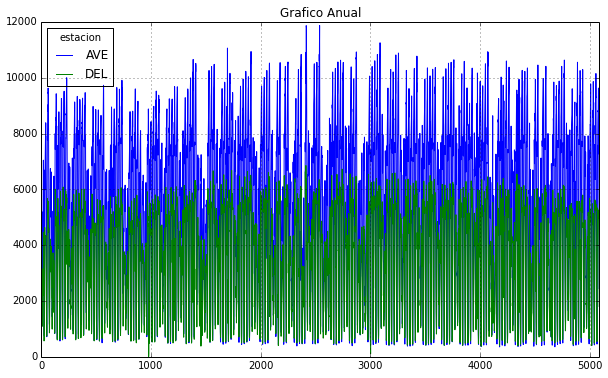

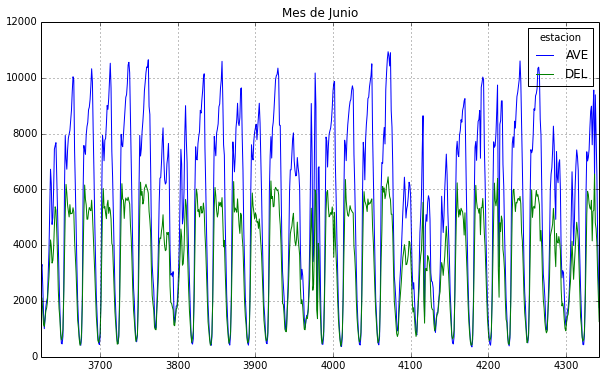

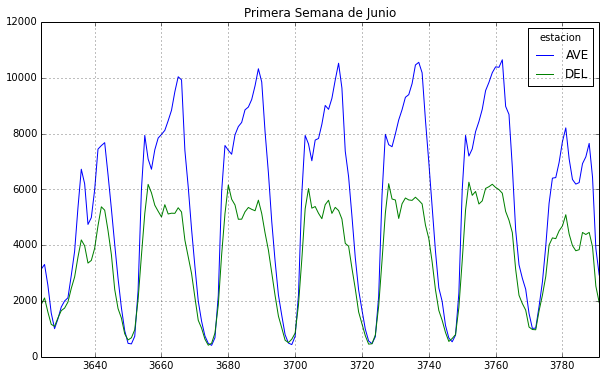

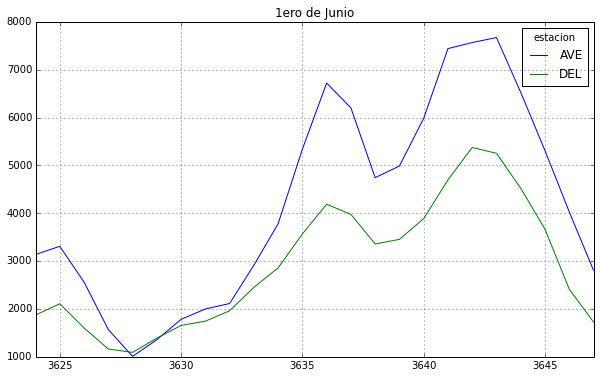

In [84]:
ts[['AVE','DEL']].plot(figsize=(10,6), title="Grafico Anual")
ts[ts.month == 6][['AVE','DEL']].plot(figsize=(10,6), title="Mes de Junio")
ts[(ts.month == 6) & (ts.day.isin([1,2,3,4,5,6,7]))][['AVE','DEL']].plot(figsize=(10,6), title="Primera Semana de Junio")
ts[(ts.month == 6) & (ts.day == 1)][['AVE','DEL']].plot(figsize=(10,6), title="1ero de Junio",)

### Prueba de distintos Modelos

In [116]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

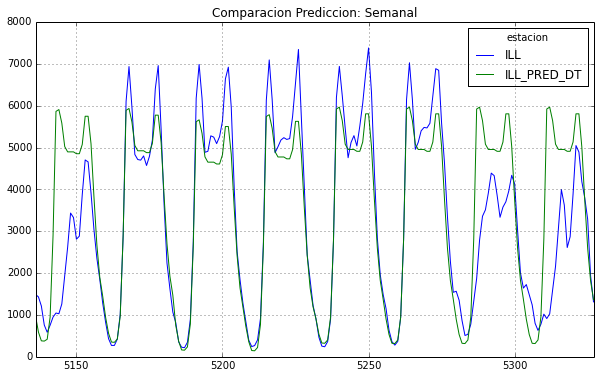

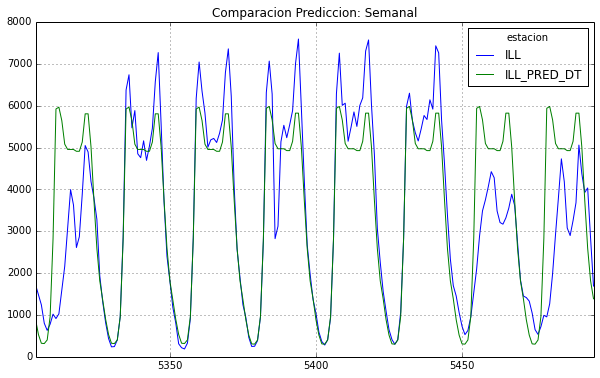

In [157]:
def train_and_predict(columns_to_exclude):
    train_data = ts.drop(columns_to_exclude,axis=1)
    test_data = ts_test.drop(columns_to_exclude,axis=1)
    X_train = train_data.drop('ILL', axis=1)
    #X_train = StandardScaler().fit_transform(X_train)
    y_train = train_data.ILL
    X_test = test_data.drop('ILL', axis=1)
    #X_test = StandardScaler().fit_transform(X_test)
    y_test = test_data.ILL

    model = GradientBoostingRegressor(loss = 'lad', warm_start=True)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    test_data['ILL_PRED_DT'] = pred
    return test_data

result = train_and_predict(columns_to_exclude = ['ALB','AVE','DEL', 'fecha','is_weekend', 'is_peak_hour', 'is_going_to_work','is_going_to_home'])

result[result.day.isin([3,4,5,6,7,8,9,10])].drop(['month','day', 'hora'], axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")
result[result.day.isin([10,11,12,13,14,15,16,17])].drop(['month','day', 'hora'], axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")

Entrenando solo con datos de Dia, Mes, Hora lo que se obtiene es una predicción uniforme para cada día. Todos los días tienen el mismo valor.

### Agregando seasonality-features
En algún lado leí que es importante meter features que ayuden a los algoritmos a encontrar los patrones dentro de cada serie. Por ejemplo, si vemos que es recurrente que los fines de semana y feriados disminuya el tráfico, es necesario agregar esa feature a los algoritmos.

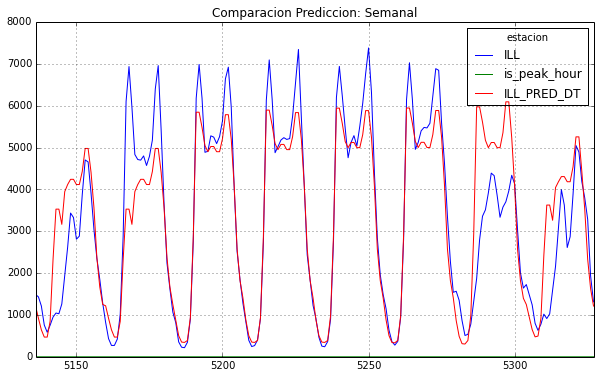

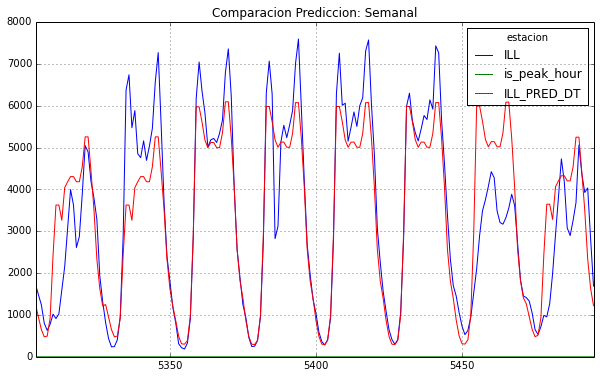

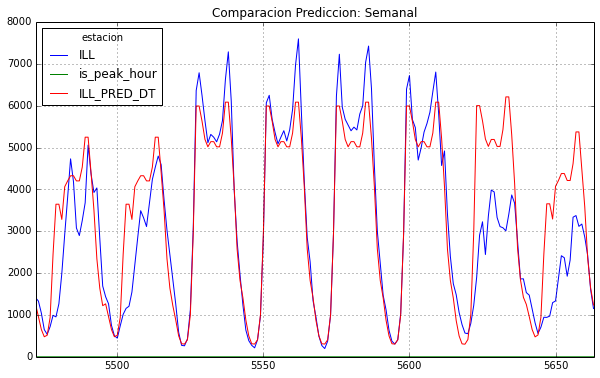

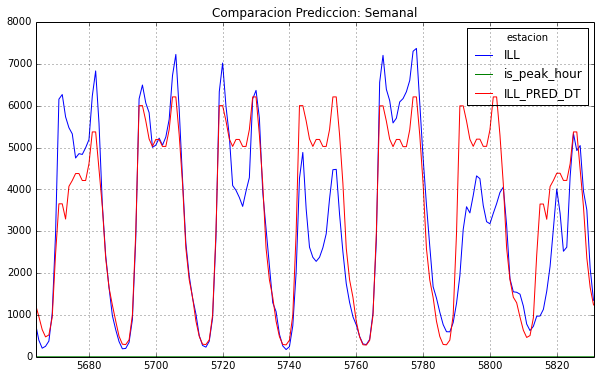

In [158]:
result = train_and_predict(columns_to_exclude= ['ALB','AVE','DEL', 'fecha'])

columns_to_drop = ['month','day', 'hora', 'is_weekend', 'is_going_to_work', 'is_going_to_home']
result[result.day.isin([3,4,5,6,7,8,9,10])].drop(columns_to_drop, axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")
result[result.day.isin([10,11,12,13,14,15,16,17])].drop(columns_to_drop, axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")
result[result.day.isin([17,18,19,20,21,22,23,24])].drop(columns_to_drop, axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")
result[result.day.isin([25,26,27,28,29,30,31])].drop(columns_to_drop, axis=1).plot(figsize(10,6), title="Comparacion Prediccion: Semanal")

Vemos como ahora hay 2 Patrones claros, uno de días de semana, y otro de fines de semana. Por alguna razón hay 3 de fines de semana y 4 de semana. Igualmente, los datos muestran una diferencia en los días Viernes.